In [2]:
from pytorch_flows import flows as fnn
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import sys

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
my_cmap = plt.cm.jet
my_cmap.set_under('white')


# Customize matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
matplotlib.rcParams['pdf.fonttype'] = 3
matplotlib.rcParams['ps.fonttype'] = 3
device = torch.device('cuda:1')

## Data

In [3]:
sys.path.append('../')
from model import YModel, OptLoss
from utils import generate_data
y_sampler = YModel()
mu_range = (-10, 10)
n_samples = 10000
x, conditions = generate_data(y_sampler, device, n_samples=n_samples, mu_range=mu_range, mu_dim=2)
x = torch.cat([x, x], dim=1)
print(x.shape, conditions.shape)

torch.Size([10000, 2]) torch.Size([10000, 3])


## Model MAF

In [4]:
modules = []
for _ in range(10):
    modules += [
        fnn.MADE(2, 128, 3, act='tanh'),
        fnn.BatchNormFlow(2),
        fnn.Reverse(2)
    ]
    
model = fnn.FlowSequential(*modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)
            
model.to(device);
sum([p.numel() for p in model.parameters()  if p.requires_grad])

178000

In [5]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 1024
dataset = torch.utils.data.TensorDataset(x, conditions)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training

iter 4677: loss = 0.722 1.220703125e-08


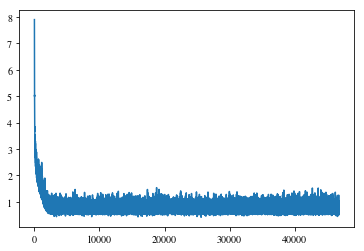

KeyboardInterrupt: 

In [6]:
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output


trainable_parametrs = list(model.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

for epoch in tqdm(range(50000)):
    for x_batch, cond_batch in tqdm(dataloader):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)

        loss = -model.log_probs(x_batch, cond_batch).mean()

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

In [7]:
model.eval();

In [8]:
model.cpu();

In [9]:
from pyro import distributions as dist
import numpy as np

In [17]:
samples[:, 0]

tensor([-15.9068, -15.9068, -15.9068,  ...,  47.5195,  47.5195,  47.5195],
       grad_fn=<SelectBackward>)

In [18]:
samples[:, 1]

tensor([-13.6247, -13.6247, -13.6247,  ...,  42.6865,  42.6865,  42.6865],
       grad_fn=<SelectBackward>)

In [14]:
samples[:, [0]]

torch.Size([500000, 1])

In [16]:
mu_range_test = (-20, 20)
batch_size = 100
mu_samples = 5000

mu = dist.Uniform(*mu_range_test).sample([mu_samples, 2]) #.to(device)
mu_r = mu.repeat(1, batch_size).view(-1, 2)
x_r = y_sampler.x_dist.sample(torch.Size([len(mu) * batch_size , 1])) # .to(device)
samples = model.sample(torch.randn(mu_samples * batch_size, 1).float(), torch.cat([mu_r, x_r],dim=1))
rs = OptLoss.SigmoidLoss(samples[:, [0]], 5, 10).reshape(-1, batch_size).mean(dim=1)

In [20]:
rs = OptLoss.SigmoidLoss(samples[:, [1]], 5, 10).reshape(-1, batch_size).mean(dim=1)

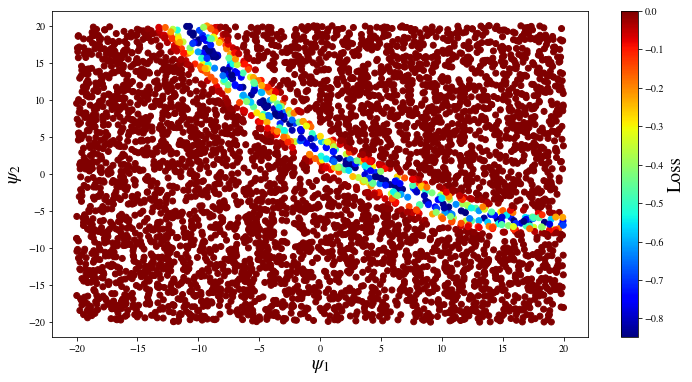

In [22]:
plt.figure(figsize=(12, 6))

mu = mu# .cpu().numpy()
plt.scatter(mu[:,0], mu[:,1], c=rs.cpu().detach().numpy(),  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)